In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pylab

from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

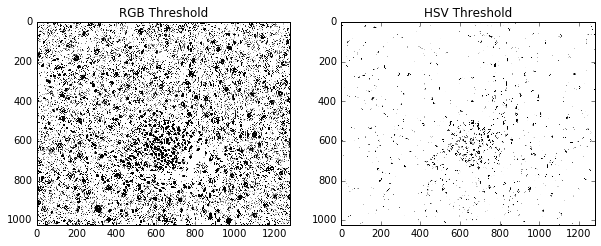

(<matplotlib.axes._subplots.AxesSubplot at 0x1af3a34fd68>,
 None)

In [3]:
img = cv2.imread("HE_img_1.tif")

#--------------------------RGB/HSV THRESHOLDING------------------------------------------------------
rgb_thresh = cv2.inRange(img, (0,0,160), (255,255,255))
plt.subplot(121), plt.imshow(rgb_thresh, cmap = 'gray'), plt.title("RGB Threshold")

b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

hsv_thresh = cv2.inRange(mask, (120,0,0), (180,255,255))
hsv_thresh = 255 - hsv_thresh
plt.subplot(122), plt.imshow(hsv_thresh, cmap = 'gray'), plt.title("HSV Threshold"), plt.show()

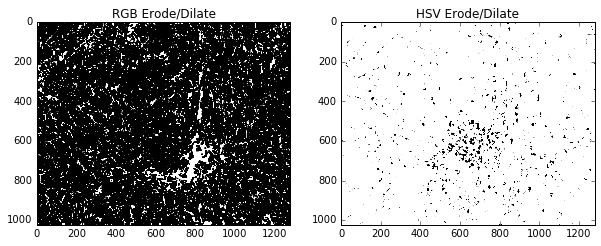

(<matplotlib.axes._subplots.AxesSubplot at 0x1af39d8ce48>,
 None)

In [4]:
#---------------RGB/HSV EROSION/DILATION-----------------------------------------------

kernel = np.ones((3,3), np.uint8)
rgb_erosion = cv2.erode(rgb_thresh, kernel, iterations = 2)
rgb_dilation = cv2.erode(rgb_erosion, kernel, iterations = 1)

hsv_erosion = cv2.erode(hsv_thresh, kernel, iterations = 2)
hsv_dilation = cv2.dilate(hsv_erosion, kernel, iterations = 2)

plt.subplot(121), plt.imshow(rgb_dilation, cmap = 'gray'), plt.title("RGB Erode/Dilate")
plt.subplot(122), plt.imshow(hsv_dilation, cmap = 'gray'), plt.title("HSV Erode/Dilate"), plt.show()

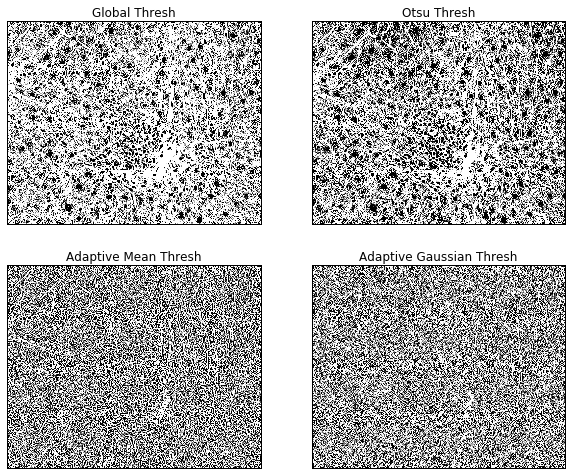

In [5]:
#-----------------------OTSU / ADAPTIVE THRESHOLDING-------------------------------
gray = cv2.imread("HE_img_1.tif", 0)
ret, global_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
ret, otsu_thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ad_thresh_mean = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
ad_thresh_gaussian = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

plt.subplot(221), plt.imshow(global_thresh, cmap = 'gray'), plt.title("Global Thresh"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(otsu_thresh, cmap = 'gray'), plt.title("Otsu Thresh"), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(ad_thresh_mean, cmap='gray'), plt.title("Adaptive Mean Thresh"), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(ad_thresh_gaussian, cmap ='gray'), plt.title("Adaptive Gaussian Thresh"), plt.xticks([]), plt.yticks([])
plt.show()

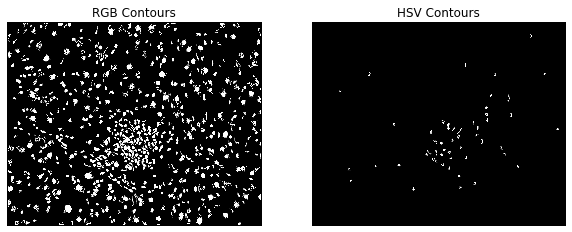

In [6]:
#-----------------RGB/HSV FIND CONTOURS---------------------------------------------
rgb_thresh = 255 - rgb_thresh
hsv_thresh = 255 - hsv_thresh
_, rgb_cnt, _ = cv2.findContours(rgb_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
_, hsv_cnt, _ = cv2.findContours(hsv_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

rgb_img = np.zeros(rgb_thresh.shape, np.uint8)
hsv_img = np.zeros(hsv_thresh.shape, np.uint8)

for c in rgb_cnt:
    if cv2.contourArea(c) > 50:
        cv2.drawContours(rgb_img, [c], 0, 255, -1)
        
for c in hsv_cnt:
    if cv2.contourArea(c) > 50:
        cv2.drawContours(hsv_img, [c], 0, 255, -1)
        
plt.subplot(121), plt.imshow(rgb_img, cmap = 'gray'), plt.title("RGB Contours"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hsv_img, cmap = 'gray'), plt.title("HSV Contours"), plt.xticks([]), plt.yticks([])
plt.show()

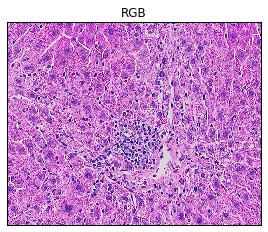

In [7]:
#--------------http://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/---------
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import argparse
#import utils
import cv2
 

img = cv2.imread("HE_img_1.tif")
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(image), plt.title("RGB"), plt.xticks([]), plt.yticks([])
# reshape the image to be a list of pixels
image = image.reshape((image.shape[0] * image.shape[1], 3))

clt = KMeans(n_clusters = 3)
clt.fit(image)

# import the necessary packages
import numpy as np
import cv2
 
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
 
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
 
    # return the histogram
    return hist

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
 
    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX
    
    # return the bar chart
    return bar

# build a histogram of clusters and then create a figure
# representing the number of pixels labeled to each color

#hist = utils.centroid_histogram(clt)
#bar = utils.plot_colors(hist, clt.cluster_centers_)
#plt.subplot(122), plt.imshow(bar), plt.title("Bar"), plt.xticks([]), plt.yticks([]),plt.show()

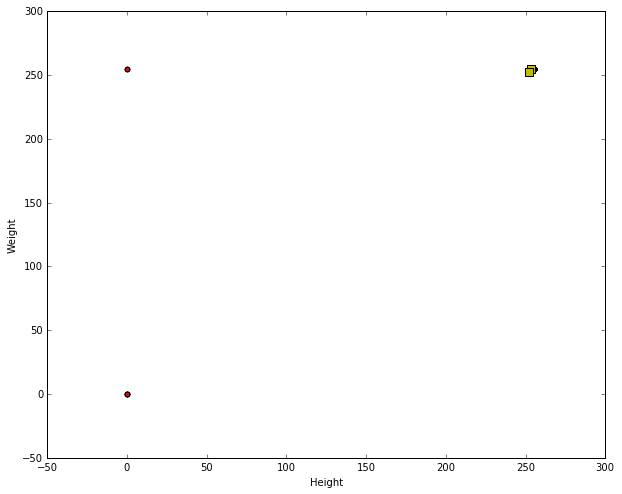

In [8]:
hsv_32_dilate = np.float32(hsv_dilation)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(hsv_32_dilate,2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now separate the data, Note the flatten()
A = hsv_32_dilate[label.ravel()==0]
B = hsv_32_dilate[label.ravel()==1]

# Plot the data
plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1],c = 'r')
plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
plt.xlabel('Height'),plt.ylabel('Weight')
plt.show()

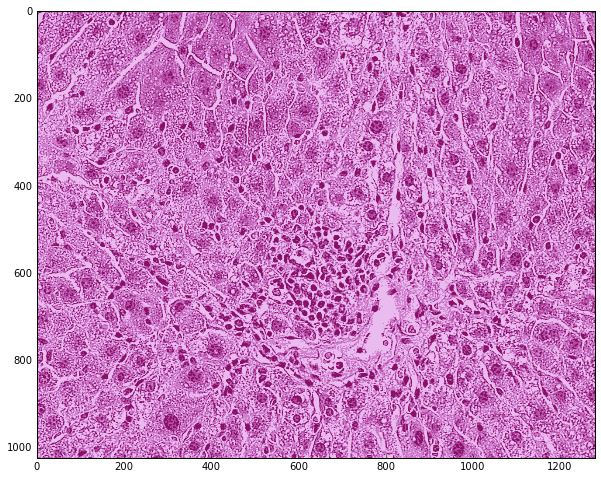

(<matplotlib.image.AxesImage at 0x1af3dbf0a58>, None)

In [9]:
import numpy as np
import cv2

img = cv2.imread('HE_img_1.tif')
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

plt.imshow(res2),plt.show()

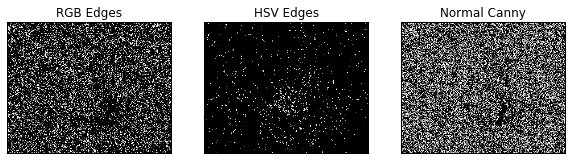

In [10]:
#-------------------CANNY EDGE DETECTION-------------------------------------
rgb_edges = cv2.Canny(rgb_thresh, 127, 255)
hsv_edges = cv2.Canny(hsv_thresh, 127, 255)
edges = cv2.Canny(gray, 127, 255)

plt.subplot(131), plt.imshow(rgb_edges, cmap = 'gray'), plt.title("RGB Edges"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(hsv_edges, cmap = 'gray'), plt.title("HSV Edges"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(edges, cmap = 'gray'), plt.title("Normal Canny"), plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Set flags (Just to avoid line break in the code)
flags = cv2.KMEANS_PP_CENTERS
hsv = np.float32(hsv_dilation)
retval, labels, centers = cv2.kmeans(hsv, 2,None,criteria,10,flags)

print(centers)

[[ 253.55932617  255.          255.         ...,  255.          253.55932617
   252.11863708]
 [ 251.98936462  252.89254761  252.89254761 ...,  253.49467468
   252.29043579  252.29043579]]


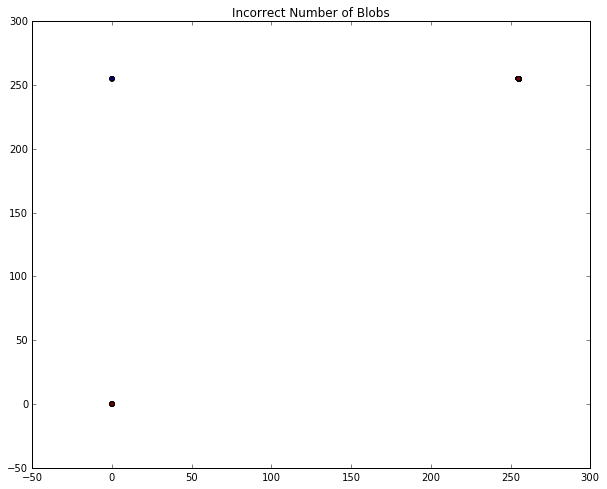

(<matplotlib.collections.PathCollection at 0x1af3ccf91d0>,
 None)

In [12]:
#------------SKLEARN CLUSTERING MODULES------------------------------
#http://scikit-learn.org/stable/modules/clustering.html
    
from sklearn import cluster
n_samples = 1500
random_state = 170
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(hsv_dilation)

plt.scatter(hsv_dilation[:, 0], hsv_dilation[:, 1], c=y_pred), plt.title("Incorrect Number of Blobs"), plt.show()

Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


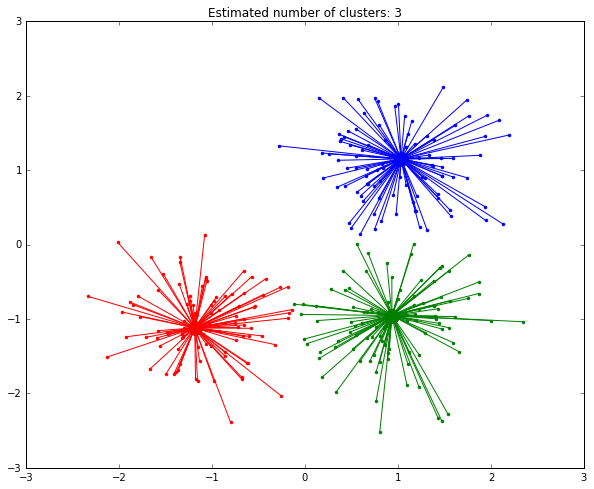

In [13]:
#---------------------AFFINITY PROPAGATION--------------------------------------
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

##############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=0)

##############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

##############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

number of estimated clusters : 3


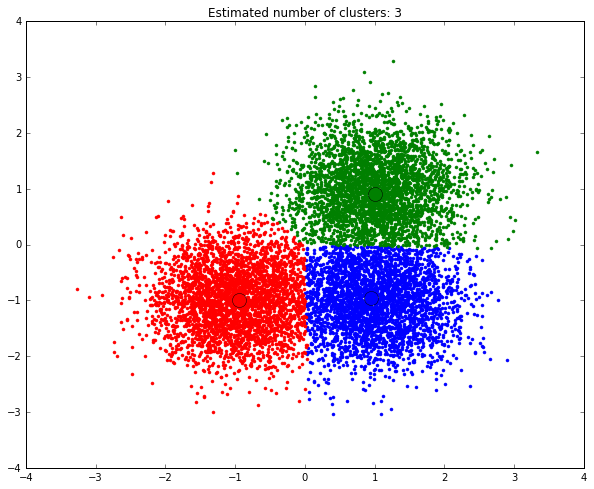

In [14]:
#----------MEAN SHIFT--------------------------

import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

###############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

###############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

###############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

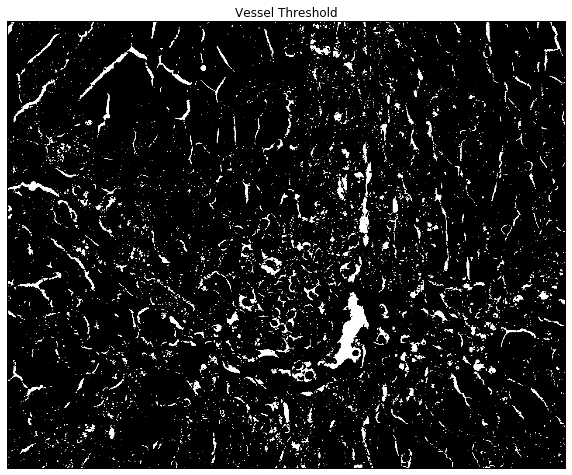

(<matplotlib.image.AxesImage at 0x1af3cd4c518>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 None)

In [15]:
#----------------------------------VESSEL DETECTION----------------------------------------
img = cv2.imread("HE_img_1.tif")

b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

thresh = cv2.inRange(mask, (0,40,0), (255,255,255))
thresh = 255 - thresh
plt.imshow(thresh, cmap = 'gray'), plt.title("Vessel Threshold"), plt.xticks([]), plt.yticks([]), plt.show()

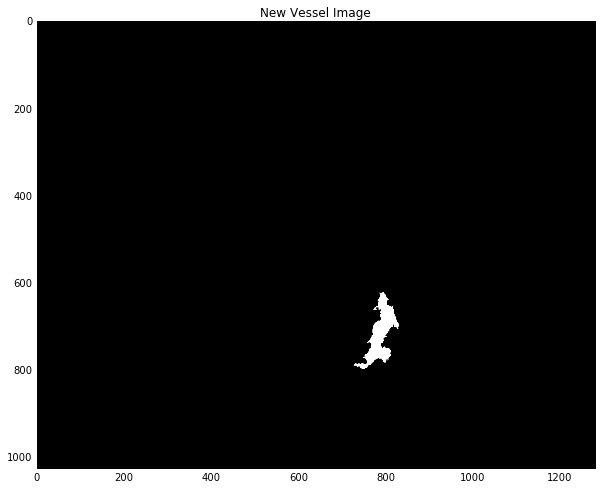

(<matplotlib.image.AxesImage at 0x1af3d53c8d0>,
 None)

In [16]:
_, vessel_cnt, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
new_vessel = np.zeros(thresh.shape, np.uint8)
for c in vessel_cnt:
    if cv2.contourArea(c) > 1500:
        cv2.drawContours(new_vessel, [c], 0, 255, -1)
    
plt.imshow(new_vessel, cmap = 'gray'), plt.title("New Vessel Image"), plt.show()

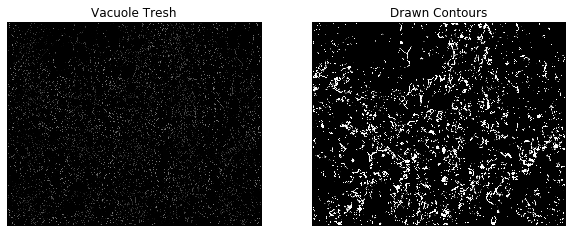

(<matplotlib.axes._subplots.AxesSubplot at 0x1af3daa0f98>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 None)

In [17]:
#----------------------------EMPTY VACUOLE DETECTION---------------------------------
img = cv2.imread("HE_img_1.tif")

b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

vacuole_thresh = cv2.inRange(mask, (0,70,0), (255,255,255))
vacuole_thresh = 255 - vacuole_thresh

plt.subplot(121), plt.imshow(vacuole_thresh, cmap = 'gray'), plt.title("Vacuole Tresh"), plt.xticks([]), plt.yticks([])

_, vacuole_cnt, _ = cv2.findContours(vacuole_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
vacuole_img = np.zeros(vacuole_thresh.shape, np.uint8)
for c in vacuole_cnt:
    if cv2.contourArea(c) <= 750 and cv2.contourArea(c) > 5:
        (x,y),(MA,ma),angle = cv2.fitEllipse(c)
        if MA/ma >= 0.4:
            cv2.drawContours(vacuole_img, [c], 0, 255, -1)
    
plt.subplot(122), plt.imshow(vacuole_img, cmap = 'gray'), plt.title("Drawn Contours"), plt.xticks([]), plt.yticks([]), plt.show()

In [18]:
#--------------------------H&E NUCLEI DETECTION---------------------------------------
img = cv2.imread("HE_img_1.tif")

#convert to hsv from bgr
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

#threshold to segment nuclei then invert
hsv_thresh = cv2.inRange(mask, (120,0,0), (190,255,255))

_, nuclei_cnt, _ = cv2.findContours(hsv_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
nuclei_img = np.zeros(hsv_thresh.shape, np.uint8)
centroid = []

#find centroids and place centroids in a list
for c in nuclei_cnt:
    if cv2.contourArea(c) > 50:
        moment = cv2.moments(c)
        if moment['m00'] != 0.0:
            cx = moment['m10']/moment['m00']
            cy = moment['m01']/moment['m00']
            centroid.append((cx,cy))
            #print("{0:.2f}".format(cx), ", {0:.2f}".format(cy))
            cv2.drawContours(nuclei_img, [c], 0, 255, -1)
    
# goes through centroids and finds distance between each centroid (timely process) and based on distance, adds the pair to list
clusters = []
for x in range(len(centroid)):
    for y in range(len(centroid)):
        distance = np.sqrt(np.square(centroid[y][0]-centroid[x][0])+np.square(centroid[y][1]-centroid[x][1]))
        if ((centroid[y],centroid[x]) not in clusters) and distance <= 200:
            #centroid looks like: (x,y)
            #clusters[0] looks like: (x,y),(x,y)
            #clusters[0][0] looks like: (x,y)
            clusters.append((centroid[x],centroid[y]))
    
lists = {}
a = 0

#goes through list of clusters, adds pair to dict
for x in range(len(clusters)):
    if len(lists) == 0:
        key = "list_" + str(a)
        lists[key] = []
        lists[key].append(clusters[x][0])
        lists[key].append(clusters[x][1])
        a += 1

    else:
        len_list = -1
        for y in list(lists):
            len_list += 1
            if clusters[x][0] in lists[y] and clusters[x][1] not in lists[y]:
                lists[y].append(clusters[x][1])
                break
            elif clusters[x][1] in lists[y] and clusters[x][0] not in lists[y]:
                lists[y].append(clusters[x][0])
                break
            elif clusters[x][0] in lists[y] and clusters[x][1] in lists[y]:
                break
            
            elif len_list == len(lists)-1:
                key = "list_" + str(a)
                lists[key] = []
                lists[key].append(clusters[x][0])
                a += 1

print("Current number of clusters: ", len(lists))
print("Number of cells in clusters: ")
for y in list(lists):
    print("\t", y,": ", len(lists[y]))
    if len(lists[y]) <= 5:
        lists.pop(y)
        
print("Current number of clusters: ", len(lists))

Current number of clusters:  4
Number of cells in clusters: 
	 list_0 :  299
	 list_1 :  29
	 list_2 :  23
	 list_3 :  1
Current number of clusters:  3


Size of Centroids:  123


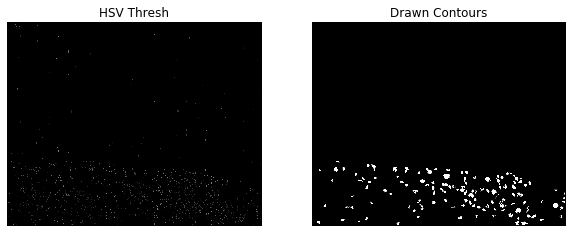

Size of Clusters:  299
Current number of clusters:  32
Number of cells in clusters: 
	 list_16 :  1
	 list_7 :  6
	 list_23 :  7
	 list_17 :  1
	 list_30 :  3
	 list_27 :  1
	 list_6 :  1
	 list_4 :  1
	 list_10 :  33
	 list_0 :  2
	 list_21 :  1
	 list_22 :  6
	 list_29 :  1
	 list_31 :  2
	 list_12 :  1
	 list_24 :  4
	 list_8 :  5
	 list_1 :  33
	 list_25 :  1
	 list_13 :  1
	 list_9 :  7
	 list_2 :  2
	 list_28 :  2
	 list_19 :  1
	 list_11 :  1
	 list_26 :  1
	 list_15 :  1
	 list_14 :  1
	 list_20 :  2
	 list_3 :  1
	 list_5 :  2
	 list_18 :  11
Current number of clusters:  2


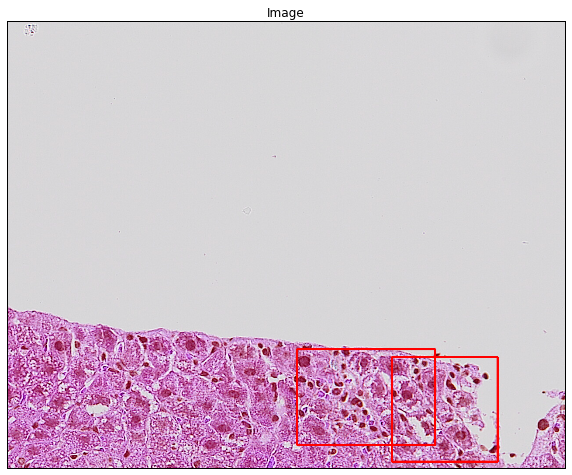

HEImgs/Image_87HE_Prj7_L84a_001_011.tif 	 1 	 33 	 70074
HEImgs/Image_87HE_Prj7_L84a_001_011.tif 	 2 	 33 	 57768


In [19]:
#--------------------------H&E NUCLEI DETECTION---------------------------------------
name = "HEImgs/Image_87HE_Prj7_L84a_001_011.tif"
img = cv2.imread(name)

#convert to hsv from bgr
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

#threshold to segment nuclei then invert
hsv_thresh = cv2.inRange(mask, (120,0,0), (190,255,255))
plt.subplot(121), plt.imshow(hsv_thresh, cmap = 'gray'), plt.title("HSV Thresh"), plt.xticks([]), plt.yticks([])

_, nuclei_cnt, _ = cv2.findContours(hsv_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
nuclei_img = np.zeros(hsv_thresh.shape, np.uint8)
centroid = []

#find centroids and place centroids in a list
for c in nuclei_cnt:
    if cv2.contourArea(c) > 50:
        moment = cv2.moments(c)
        if moment['m00'] != 0.0:
            cx = moment['m10']/moment['m00']
            cy = moment['m01']/moment['m00']
            centroid.append((cx,cy))
            #print("{0:.2f}".format(cx), ", {0:.2f}".format(cy))
            cv2.drawContours(nuclei_img, [c], 0, 255, -1)
            
print("Size of Centroids: ", len(centroid))
# goes through centroids and finds distance between each centroid (timely process) and based on distance, adds the pair to list
plt.subplot(122), plt.imshow(nuclei_img, cmap = 'gray'), plt.title("Drawn Contours"), plt.xticks([]), plt.yticks([]), plt.show()
clusters = []
for x in range(len(centroid)):
    for y in range(len(centroid)):
        distance = np.sqrt(np.square(centroid[y][0]-centroid[x][0])+np.square(centroid[y][1]-centroid[x][1]))
        if ((centroid[y],centroid[x]) not in clusters) and distance <= 50:
            #centroid looks like: (x,y)
            #clusters[0] looks like: (x,y),(x,y)
            #clusters[0][0] looks like: (x,y)
            clusters.append((centroid[x],centroid[y]))
print("Size of Clusters: ", len(clusters))
lists = {}
a = 0

#goes through list of clusters, adds pair to dict
for x in range(len(clusters)):
    if len(lists) == 0:
        key = "list_" + str(a)
        lists[key] = []
        lists[key].append(clusters[x][0])
        lists[key].append(clusters[x][1])
        a += 1

    else:
        len_list = -1
        for y in list(lists):
            len_list += 1
            if clusters[x][0] in lists[y] and clusters[x][1] not in lists[y]:
                lists[y].append(clusters[x][1])
                break
            elif clusters[x][1] in lists[y] and clusters[x][0] not in lists[y]:
                lists[y].append(clusters[x][0])
                break
            elif clusters[x][0] in lists[y] and clusters[x][1] in lists[y]:
                break
            
            elif len_list == len(lists)-1:
                key = "list_" + str(a)
                lists[key] = []
                lists[key].append(clusters[x][0])
                a += 1

print("Current number of clusters: ", len(lists))
print("Number of cells in clusters: ")
for y in list(lists):
    print("\t", y,": ", len(lists[y]))
    if len(lists[y]) <= 15:
        lists.pop(y)
        
print("Current number of clusters: ", len(lists))

cluster_results = {}
a = 0
for y in list(lists):
        a += 1
        topmost = 1280
        bottommost = 0
        leftmost = 1280
        rightmost = 0
        for x in range(len(lists[y])):
            if (lists[y][x][0] < leftmost):
                leftmost = int(lists[y][x][0])
            if (lists[y][x][1] < topmost):
                topmost = int(lists[y][x][1])
            if (lists[y][x][0] > rightmost):
                rightmost = int(lists[y][x][0])
            if (lists[y][x][1] > bottommost):
                bottommost = int(lists[y][x][1])
        cluster_results[a] = []
        cluster_results[a].append(len(lists[y]))
        size = (bottommost-topmost)*(rightmost-leftmost)
        cluster_results[a].append(size)
        cv2.rectangle(img, (leftmost-5, bottommost-5), (rightmost+5, topmost+5), (255,0,0), 4)
            
plt.imshow(img), plt.title("Image"), plt.xticks([]), plt.yticks([]), plt.show()
for a in cluster_results:
    print(name,'\t',a,'\t', str(cluster_results[a][0]), '\t', str(cluster_results[a][1]))

In [20]:
name = "HEImgs/Image_87HE_Prj7_L84a_002_019.tif"
img = cv2.imread(name)

#convert to hsv from bgr
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

h = mask[:,:,0]
output = np.percentile(h, 5)
print(output)

197.0


Binary Count:  69636
Nuclei cnt: 7723
Binary Count cleaned up:  39340
Size of Centroids:  245


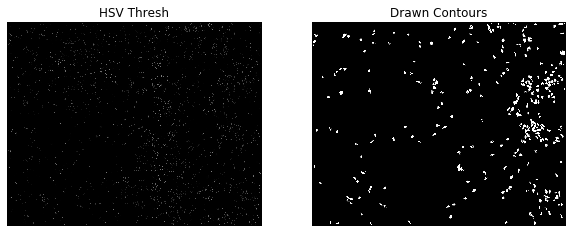

Size of Clusters:  566
Current number of clusters:  101
Number of cells in clusters: 
	 list_63 :  19
	 list_94 :  3
	 list_59 :  4
	 list_70 :  1
	 list_77 :  1
	 list_97 :  1
	 list_52 :  33
	 list_33 :  1
	 list_29 :  1
	 list_31 :  1
	 list_73 :  1
	 list_12 :  1
	 list_66 :  1
	 list_25 :  1
	 list_93 :  2
	 list_76 :  2
	 list_40 :  2
	 list_47 :  1
	 list_19 :  1
	 list_57 :  1
	 list_8 :  2
	 list_20 :  1
	 list_74 :  1
	 list_78 :  1
	 list_16 :  5
	 list_83 :  1
	 list_62 :  1
	 list_36 :  1
	 list_50 :  1
	 list_6 :  1
	 list_42 :  2
	 list_4 :  1
	 list_39 :  1
	 list_34 :  1
	 list_85 :  3
	 list_90 :  1
	 list_49 :  1
	 list_24 :  1
	 list_46 :  2
	 list_100 :  4
	 list_37 :  2
	 list_68 :  4
	 list_79 :  3
	 list_81 :  2
	 list_86 :  1
	 list_15 :  2
	 list_53 :  1
	 list_14 :  1
	 list_3 :  1
	 list_92 :  1
	 list_18 :  1
	 list_61 :  2
	 list_7 :  1
	 list_65 :  5
	 list_17 :  1
	 list_30 :  1
	 list_88 :  1
	 list_23 :  1
	 list_89 :  1
	 list_58 :  1
	 list_64 :  2
	

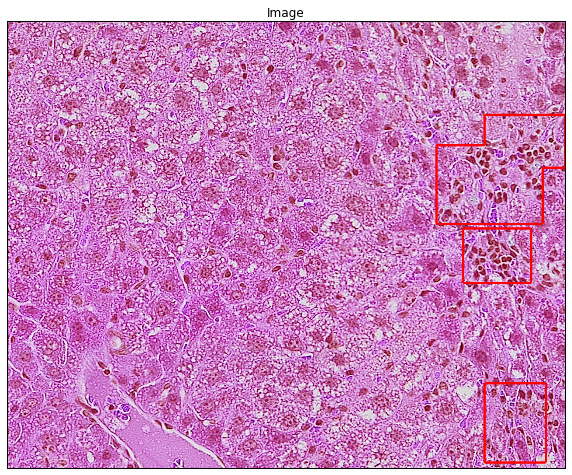

HEImgs/Image_87HE_Prj7_L84a_001_029.tif 	 1 	 15 	 25513.0
HEImgs/Image_87HE_Prj7_L84a_001_029.tif 	 2 	 18 	 19492.0
HEImgs/Image_87HE_Prj7_L84a_001_029.tif 	 3 	 42 	 59335.0


In [26]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

#--------------------------H&E NUCLEI DETECTION---------------------------------------
name = "HEImgs/Image_87HE_Prj7_L84a_001_029.tif"
img = cv2.imread(name)

#convert to hsv from bgr
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

#threshold to segment nuclei then invert
hsv_thresh = cv2.inRange(mask, (120,0,0), (190,255,235))
plt.subplot(121), plt.imshow(hsv_thresh, cmap = 'gray'), plt.title("HSV Thresh"), plt.xticks([]), plt.yticks([])

        
print("Binary Count: ", cv2.countNonZero(hsv_thresh))
_, nuclei_cnt, _ = cv2.findContours(hsv_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
nuclei_img = np.zeros(hsv_thresh.shape, np.uint8)
centroid = []
print("Nuclei cnt:", len(nuclei_cnt))
#find centroids and place centroids in a list
for c in nuclei_cnt:
    if cv2.contourArea(c) > 50:
        moment = cv2.moments(c)
        if moment['m00'] != 0.0:
            cx = moment['m10']/moment['m00']
            cy = moment['m01']/moment['m00']
            centroid.append((cx,cy))
            #print("{0:.2f}".format(cx), ", {0:.2f}".format(cy))
            cv2.drawContours(nuclei_img, [c], 0, 255, -1)

print("Binary Count cleaned up: ", cv2.countNonZero(nuclei_img))
cv2.imwrite("contours.tif", nuclei_img)
print("Size of Centroids: ", len(centroid))
# goes through centroids and finds distance between each centroid (timely process) and based on distance, adds the pair to list
plt.subplot(122), plt.imshow(nuclei_img, cmap = 'gray'), plt.title("Drawn Contours"), plt.xticks([]), plt.yticks([]), plt.show()
clusters = []
for x in range(len(centroid)):
    for y in range(len(centroid)):
        distance = np.sqrt(np.square(centroid[y][0]-centroid[x][0])+np.square(centroid[y][1]-centroid[x][1]))
        if ((centroid[y],centroid[x]) not in clusters) and distance <= 50:
            #centroid looks like: (x,y)
            #clusters[0] looks like: (x,y),(x,y)
            #clusters[0][0] looks like: (x,y)
            clusters.append((centroid[x],centroid[y]))
print("Size of Clusters: ", len(clusters))
lists = {}
a = 0

#goes through list of clusters, adds pair to dict
for x in range(len(clusters)):
    if len(lists) == 0:
        key = "list_" + str(a)
        lists[key] = []
        lists[key].append(clusters[x][0])
        lists[key].append(clusters[x][1])
        a += 1

    else:
        len_list = -1
        for y in list(lists):
            len_list += 1
            if clusters[x][0] in lists[y] and clusters[x][1] not in lists[y]:
                lists[y].append(clusters[x][1])
                break
            elif clusters[x][1] in lists[y] and clusters[x][0] not in lists[y]:
                lists[y].append(clusters[x][0])
                break
            elif clusters[x][0] in lists[y] and clusters[x][1] in lists[y]:
                break
            
            elif len_list == len(lists)-1:
                key = "list_" + str(a)
                lists[key] = []
                lists[key].append(clusters[x][0])
                a += 1

print("Current number of clusters: ", len(lists))
print("Number of cells in clusters: ")
for y in list(lists):
    print("\t", y,": ", len(lists[y]))
    if len(lists[y]) < 15:
        lists.pop(y)

rectangle_mask = np.zeros(hsv_thresh.shape, np.uint8)
cluster_results = {}
for y in list(lists):
        #a += 1
        topmost = 1280
        bottommost = 0
        leftmost = 1280
        rightmost = 0
        for x in range(len(lists[y])):
            if (lists[y][x][0] < leftmost):
                leftmost = int(lists[y][x][0])
            if (lists[y][x][1] < topmost):
                topmost = int(lists[y][x][1])
            if (lists[y][x][0] > rightmost):
                rightmost = int(lists[y][x][0])
            if (lists[y][x][1] > bottommost):
                bottommost = int(lists[y][x][1])
        #cluster_results[a] = []
        #cluster_results[a].append(len(lists[y]))
        #size = (bottommost-topmost)*(rightmost-leftmost)
        #cluster_results[a].append(size)
        cv2.rectangle(rectangle_mask, (leftmost-5, bottommost-5), (rightmost+5, topmost+5), 255, 4)
            
            
cluster_results = {}
a = 0  
_, rectangle_cnt, _ = cv2.findContours(rectangle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for c in rectangle_cnt:
    a +=1
    point_cnt = 0
    cluster_results[a] = []
    for i in range(len(centroid)):
        num = cv2.pointPolygonTest(c, centroid[i], False)
        if num == 0 or num == 1:
            point_cnt += 1
    cluster_results[a].append(point_cnt)
    cluster_results[a].append(cv2.contourArea(c))
    cv2.drawContours(img, [c], 0, (255,0,0), 4)
    
print("Current clusters: ", len(rectangle_cnt))
plt.imshow(img), plt.title("Image"), plt.xticks([]), plt.yticks([]), plt.show()
for a in cluster_results:
    print(name,'\t',a,'\t', str(cluster_results[a][0]), '\t', str(cluster_results[a][1]))